## Data Preprocessing

1. **Process Annotations**: Read the annotation files for each dataset and convert the event data into a unified format. For example, for the MUSP dataset, annotations are transformed into a list of events where each event is represented as a tuple containing the event type ('m' for music or 's' for speech), start time, and end time.

2. **Save Processed Data**: Save the processed data, including the audio file paths and their corresponding events, into a new CSV file. This structured data will serve as the input for data generator.

In [ ]:
import os
import csv

In [ ]:
def get_files(data_path:str, extensions:str) -> list:
  """
  Get a list of files in the specified data path with the given extensions.

  Parameters:
  - data_path (str): The path to the directory containing the files.
  - extensions (str or tuple): The file extensions to filter by.

  Returns:
  - files (list): A list of file names that match the specified extensions.
  """
  return [f for f in os.listdir(data_path) if f.endswith(extensions)]


def write_data_to_csv(data:dict, output_path:str) -> None:
  """
  Takes a dictionary and writes it to a CSV file.

  Parameters:
  - data (dict): A dictionary containing the data to be written to the CSV file.
  - output_path (str): The path to the output CSV file.
  """
  with open(output_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filepath', 'events'])

    for key, value in data.items():
      if value:
        writer.writerow([key, value])

### Musp

In [ ]:
MUSP_ANNOTATIONS_PATH = './data/musp/'

# Get all the annotation files (name) in the data path:
files = get_files(MUSP_ANNOTATIONS_PATH, extensions='.csv')

# !! Remove some annotation files that are not linked to audio files:
files.remove('theconcert2_v2.csv')  # no file named 'theconcert2_v2.mp3'
files.remove('UTMA-26_v2.csv')      # no file named 'UTMA-26_v2.mp3'

musp_data = {}  # This dictionary will store for each audio file the list of events
                # i.e. {'./data/musp/audio_file.mp3': [('s', 20, 22), ('s', 25, 27), ...]}

for f in files:
    with open(MUSP_ANNOTATIONS_PATH + f, 'r') as file:

        reader = csv.reader(file)

        MP3_FILE_PATH = './data/musp/' + f.split('.')[0] + '.mp3'
        musp_data[MP3_FILE_PATH] = []       # Initialize the list of events for this file

        print(f'Processing {MP3_FILE_PATH}...')

        for row in reader: # Read the events from the CSV file
            
            if not row: # Skip empty lines
              continue
  
            start = float(row[0])       # Start time of the event (in seconds)
            duration = float(row[1])    # Duration of the event (in seconds)
            end_time = start + duration # End time of the event (in seconds)
            label = str(row[2])         # Label of the event  

            assert (start < end_time), f"Start time ({start}) must be less than end time ({end_time})"
            # Append the event to the list of events for this audio file:
            musp_data[MP3_FILE_PATH].append(
              (label, start, end_time) 
            )                          

write_data_to_csv(musp_data, './data/musp.csv')

### TUT (development)

In [ ]:


AUDIO_1_PATH = './data/tut/TUT-sound-events-2017-development/TUT-sound-events-2017-development.audio.1/TUT-sound-events-2017-development/audio/street/'
AUDIO_2_PATH = './data/tut/TUT-sound-events-2017-development/TUT-sound-events-2017-development.audio.2/TUT-sound-events-2017-development/audio/street/'
DATA_PATH = './data/tut/'

DEVELOPMENT_ANNOTATIONS_PATH = './data/tut/TUT-sound-events-2017-development/TUT-sound-events-2017-development.meta/TUT-sound-events-2017-development/meta/street/'

files = get_files(DEVELOPMENT_ANNOTATIONS_PATH, extensions='.ann')

tut_data = {}
for f in files:
    with open(DEVELOPMENT_ANNOTATIONS_PATH + f, 'r'):

        f_name = f.split('.')[0] + '.wav'

        if f_name in ['a128.wav', 'a131.wav', 'b007.wav', 'b093.wav']:
            f_path = AUDIO_2_PATH + f_name
        else:
          f_path = AUDIO_1_PATH + f_name
          
        tut_data[f_path] = []

        print(f'Processing {f_path}...')

        with open(DEVELOPMENT_ANNOTATIONS_PATH + f, 'r') as file:

            reader = csv.reader(file)

            for row in reader:
                if row:
                    # split in \t and get the start and end time
                    row = row[0].split('\t')
                    start = float(row[2])
                    end = float(row[3])
                    label = row[4]
                    tut_data[f_path].append(
                        (label, start, end)
                    )

write_data_to_csv(tut_data, './data/tut.csv')

### Urban-SED (train)

In [ ]:
import jams
URBAN_SED_ANNOTATIONS_PATH = './data/urbansed/annotations/train/'

files = get_files(URBAN_SED_ANNOTATIONS_PATH, extensions='jams')

def parse_jams_file(jams_file):
    """
    Parse a JAMS file and extract the annotations.

    Parameters:
    - jams_file (str): The path to the JAMS file.

    Returns:
    - events (list): A list of tuples containing the event type, start time, and end time.
    """
    jam = jams.load(jams_file)
    events = []
    for annotation in jam.annotations:

        for obs in annotation.data:

            start_time = obs.value['event_time']
            end_time = obs.value['event_time'] + obs.value['event_duration']
            label = obs.value['label']
            events.append((label, start_time, end_time))

        return events

DATA_PATH = './data/urbansed/annotations/train/'
AUDIO_PATH = './data/urbansed/audio/train/'

urbansed_data = {}
for f in files:
    f_path = DATA_PATH + f
    f = f.split('.')[0] + '.wav'
    urbansed_data[AUDIO_PATH+f] = parse_jams_file(f_path)

write_data_to_csv(urbansed_data, './data/urbansed.csv')

# Data Generator

In [2]:
import pandas as pd

urbansed_df = pd.read_csv('./data/urbansed.csv')
urbansed_df.events = urbansed_df.events.apply(eval)

urbansed_df.head()

,filepath,events
0,./data/urbansed/audio/train/soundscape_train_b...,"[(noise, 0, 10.0), (jackhammer, 3.125421616610..."
1,./data/urbansed/audio/train/soundscape_train_b...,"[(noise, 0, 10.0), (siren, 3.077712542609878, ..."
2,./data/urbansed/audio/train/soundscape_train_b...,"[(noise, 0, 10.0), (jackhammer, 0.519876749784..."
3,./data/urbansed/audio/train/soundscape_train_b...,"[(noise, 0, 10.0), (street_music, 0.8799605873..."
4,./data/urbansed/audio/train/soundscape_train_b...,"[(noise, 0, 10.0), (jackhammer, 4.298369988203..."


In [3]:
from utils import AudioFile

audio_01 = AudioFile(file_path='./data/urbansed/audio/train/soundscape_train_unimodal1769.wav')

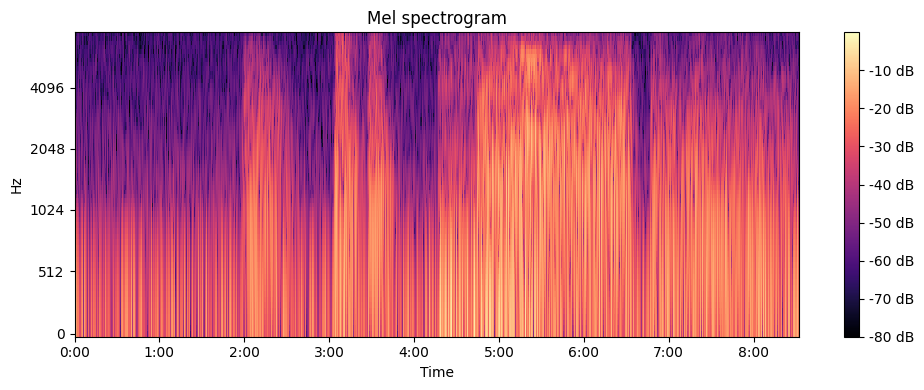

In [4]:
audio_01.mel_spectrogram.plot()

In [5]:
from utils import YOHODataGenerator

urbansed_gen = YOHODataGenerator(file_paths=urbansed_df.filepath, labels=urbansed_df.events, batch_size=1, shuffle=False, input_shape=(128, 128), output_shape=(1, 1))

In [13]:
urbansed_gen[0]

(tensor([[[-0.0329,  0.4425,  0.5799,  ...,  1.3928, -0.0962, -0.2009],
          [-0.0348,  0.4374,  0.5723,  ...,  1.3889, -0.0655, -0.2012],
          [-0.0381,  0.4289,  0.5596,  ...,  1.3824, -0.0217, -0.2018],
          ...,
          [-1.1914, -1.4997, -1.3121,  ..., -1.9538, -1.2554, -2.2680],
          [-1.2754, -1.5072, -1.2038,  ..., -1.7031, -1.2814, -2.9766],
          [-1.3882, -1.6844, -1.2313,  ..., -1.4122, -1.3381, -2.5239]]]),
 [('noise', 0, 10.0),
  ('jackhammer', 3.1254216166103967, 4.081540068079489),
  ('dog_bark', 4.272822510637965, 5.995148792556066),
  ('drilling', 4.644565713394142, 7.674565713394141)])